In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.utils import from_networkx

import torch_geometric.transforms as T

#from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [11]:
# output_dim replaced by 1
output_dim = 2
class GNNStackClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNStack, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        return pyg_nn.GCNConv(input_dim, hidden_dim)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)
        return F.log_softmax(x,dim=1)

    def loss(self, pred, actual):
        #print(pred.numpy())
        #print(actual.numpy())
        #print('\n\n\n')
        return F.nll_loss(pred, actual)

In [15]:
# output_dim replaced by 1
output_dim = 1
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNStack, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        return pyg_nn.GCNConv(input_dim, hidden_dim)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)
        return x

    def loss(self, pred, actual):
        #print(pred.numpy())
        #print(actual.numpy())
        #print('\n\n\n')
        return F.mse_loss(pred, actual)

In [29]:
LG = nx.read_graphml('experiments/preprocessed/san_francisco.graphml')
node_feature_list = ['speed_mph_p85', 'length', 'oneway']
edge_feature_list = ['x','y']

lg_node_attr = {}
node_relabel = {}

IDs = {}
cur_ID = 0

#To make torch_geometric.data extraction easier, remove every node that doesn't have ALL of the features in node_feature_list
remove = []
insert = []
num_train = 24580*0.8
cur_num_train = 0
#seperate into train and test
for key,_ in LG.nodes(data=True):
    new_edge_data = LG.nodes()[key]
    skip = False
    for k in list(new_edge_data.keys()):
        if k not in node_feature_list:
            del new_edge_data[k]
    for k in node_feature_list:
        if k not in new_edge_data:
            skip = True
            break
    if skip == True:
        remove.append(key)
        continue
    x = []
    edge_x_y = {}
    for k,v in new_edge_data.items():
        if k == 'speed_mph_p85':
           # if v > 30:
            #    edge_x_y['y'] = 0
            #else:
            #    edge_x_y['y'] = 1
            edge_x_y['y'] = [v]
            continue
        x.append(v)
    edge_x_y['x'] = x
    if cur_num_train > num_train:
        edge_x_y['train_mask'] = False
        edge_x_y['test_mask'] = True
    else:
        edge_x_y['train_mask'] = True
        edge_x_y['test_mask'] = False 
    lg_node_attr[cur_ID] = edge_x_y
    node_relabel[key] = cur_ID
    IDs[cur_ID] = key
    cur_ID+=1
    cur_num_train+=1
    
for i in remove:
    LG.remove_node(i)
    
nx.relabel.relabel_nodes(LG,node_relabel,False)
#print(lg_node_attr)
nx.set_node_attributes(LG,lg_node_attr)
count = 0
for n in LG.nodes(data=True):
    count+=1
print(count)

nx.set_edge_attributes(LG,{})
for n in LG.nodes(data=True):
    print(n)
    break
print('\n')
for e in LG.edges(data=True):
    print(e)
    break

#nx.write_graphml(LG,'experiments/preprocessed/' + CITY_NAME + ".graphml")

pyData = from_networkx(LG)

20580
(17191, {'oneway': True, 'length': 93.765, 'speed_mph_p85': 30.125999999999998, 'y': [30.125999999999998], 'x': [True, 93.765], 'train_mask': True, 'test_mask': False})


(17191, 7700, {})


In [30]:
print(pyData.num_node_features)
loader = DataLoader([pyData], batch_size=1)
print(loader.dataset)
print(len(loader.dataset))

2
[Data(edge_index=[2, 60626], length=[20580], oneway=[20580], speed_mph_p85=[20580], test_mask=[20580], train_mask=[20580], x=[20580, 2], y=[20580, 1])]
1


tensor([ True,  True,  True,  ...,  True,  True, False]) ----
Epoch 0. Loss: 462.6579. Test accuracy: 0.0000
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
Epoch 10. Loss: 137.2791. Test accuracy: 0.0000
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  T

tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
Epoch 130. Loss: 58.7354. Test accuracy: 0.0000
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True,  True,  ...,  True,  True, False]) ----
tensor([ True,  True, 

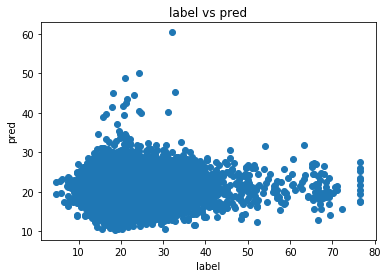

In [31]:
    test_loader = loader = DataLoader([pyData], batch_size=1)

    # build model
    model = GNNStack(max(pyData.num_node_features, 1), 32)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            print(batch.train_mask, '----')
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        #writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            #writer.add_scalar("test accuracy", test_acc, epoch)
    for data in test_loader:
        pred = model(data).detach().numpy()
        label = data.y.detach().numpy()
        #plt.plot(range(len(label)),label)
        #plt.plot(range(len(label)),pred)
        plt.scatter(label,pred)
        plt.ylabel('pred')
        plt.xlabel('label')
        plt.title('label vs pred')
        plt.show()
        break
    #return model


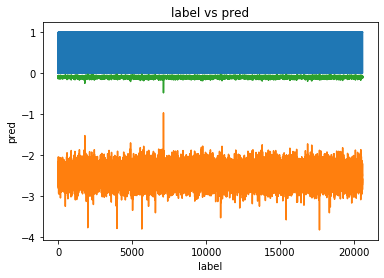

In [10]:
    for data in test_loader:
        pred = model(data).detach().numpy()
        label = data.y.detach().numpy()
        plt.plot(range(len(label)),label)
        plt.plot(range(len(pred)),pred)
        #plt.scatter(label,pred)
        plt.ylabel('pred')
        plt.xlabel('label')
        plt.title('label vs pred')
        plt.show()
        #print(pred)
        #for i in range(len(pred)):
        #    print(label[i],pred[i])
        #print(label)
        break

In [6]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
        #print(label, pred)
        correct += pred.eq(label).sum().item()
    total = 0
    for data in loader.dataset:
        total += torch.sum(data.test_mask).item()
    return correct / total